In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
from copy import deepcopy
import joblib
from pprint import pprint
from math import ceil
import cortex
from neuro.config import repo_dir, PROCESSED_DIR, setup_freesurfer
from collections import defaultdict
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import gemv
from neuro.flatmaps_helper import load_flatmaps
import sasc.viz
from neuro import analyze_helper
import nibabel as nib
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from neuro.features.questions.gpt4 import QS_35_STABLE
setup_freesurfer()

subject = 'S02'
subjects = [f'S0{i}' for i in range(1, 9) if not i == 6] # there's some problem with S06 surf2surf
# subjects = ['S01', 'S02', 'S03']

### Load flatmaps

In [2]:
d = defaultdict(list)
for subject in subjects:
    # if subject in ['S01', 'S02', 'S03']:
    # settings = ['individual_gpt4',
    # 'individual_gpt4_wordrate', 'shapley_35']
    # else:
    settings = ['individual_gpt4_ndel=1_pc_new']
    flatmaps_qa_list = defaultdict(list)
    for setting in settings:
        flatmaps_qa_dict = joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
        for q in flatmaps_qa_dict.keys():
            flatmaps_qa_list[q].append(flatmaps_qa_dict[q])
    flatmaps_qa_dict = {
        q: np.mean(flatmaps_qa_list[q], axis=0)
        for q in flatmaps_qa_list.keys()
    }
    # for k in sorted(flatmaps_qa_dict.keys()):
    for k in QS_35_STABLE:
        # print(k, flatmaps_qa_dict[k])
        # d[f'q_{subject}'].append(k)
        d[subject].append(flatmaps_qa_dict[k])

    # print(subject, len(flatmaps_qa_dict))
df = pd.DataFrame(d)
# df.set_index('q_S01', inplace=True)
df.index = QS_35_STABLE
df.index.name = 'question'
df = df[df.index.isin(QS_35_STABLE)]
assert df.shape[0] == 35

In [ ]:
# save mni vols
mni_arrs_list = []
for q in tqdm(df.index):
    mni_vols = []
    for subject in subjects:
        print(subject)
        subj_vol = cortex.Volume(df.loc[q][subject], 'UT' + subject,
                                 xfmname=f"UT{subject}_auto")
        mni_vol = neurosynth.subj_vol_to_mni_surf(subj_vol, subject)
        mni_vols.append(deepcopy(mni_vol))
        mni_arrs = [mni_vol.data for mni_vol in mni_vols]
    mni_arrs_list.append(deepcopy(mni_arrs))
joblib.dump(mni_arrs_list, 'mni_arrs_list.pkl')

In [3]:
# load arrs for first 3 subjects
mni_arrs_list = joblib.load('mni_arrs_list.pkl')
mni_arrs_list = [a[:3] for a in mni_arrs_list]
subjects = subjects[:3]

# compute correlations
corrs_list = []
for j, q in enumerate(df.index):
    # compute correlation between each one and mean of the others
    mni_arrs = np.array(mni_arrs_list[j])
    corrs_loo = []
    for i in range(mni_arrs.shape[0]):
        mni_arr = mni_arrs[i]
        other_mni_arrs = np.delete(mni_arrs, i, axis=0)
        mean_other_mni_arr = np.mean(other_mni_arrs, axis=0)
        corr = np.corrcoef(mni_arr.flatten(),
                           mean_other_mni_arr.flatten())[0, 1]
        # print(f'corr between {i} and mean of others', corr)
        corrs_loo.append(corr)
    corrs_list.append(corrs_loo)
corrs_df = pd.DataFrame(np.array(corrs_list), columns=subjects, index=df.index)

# flatten with column name as value for a new column
corrs_df = corrs_df.melt(
    ignore_index=False, var_name='subject', value_name='corrs').reset_index()
corrs_df.rename(columns={'question': 'questions'}, inplace=True)

In [5]:
corrs_df

,questions,subject,corrs
0,Does the sentence describe a personal reflecti...,S01,0.348768
1,Does the sentence contain a proper noun?,S01,0.358852
2,Does the sentence describe a physical action?,S01,0.158650
3,Does the sentence describe a personal or socia...,S01,0.210818
4,Does the sentence involve the mention of a spe...,S01,0.174364
...,...,...,...
100,Does the input contain a measurement?,S03,0.121476
101,Does the sentence describe a physical sensation?,S03,0.312653
102,Does the sentence include a direct speech quot...,S03,0.302610
103,"Is the sentence reflective, involving self-ana...",S03,0.277782


mean corr 0.2996681538479328
S01 corr 0.30113093477913355
S02 corr 0.30390626174404706
S03 corr 0.29396726502061776


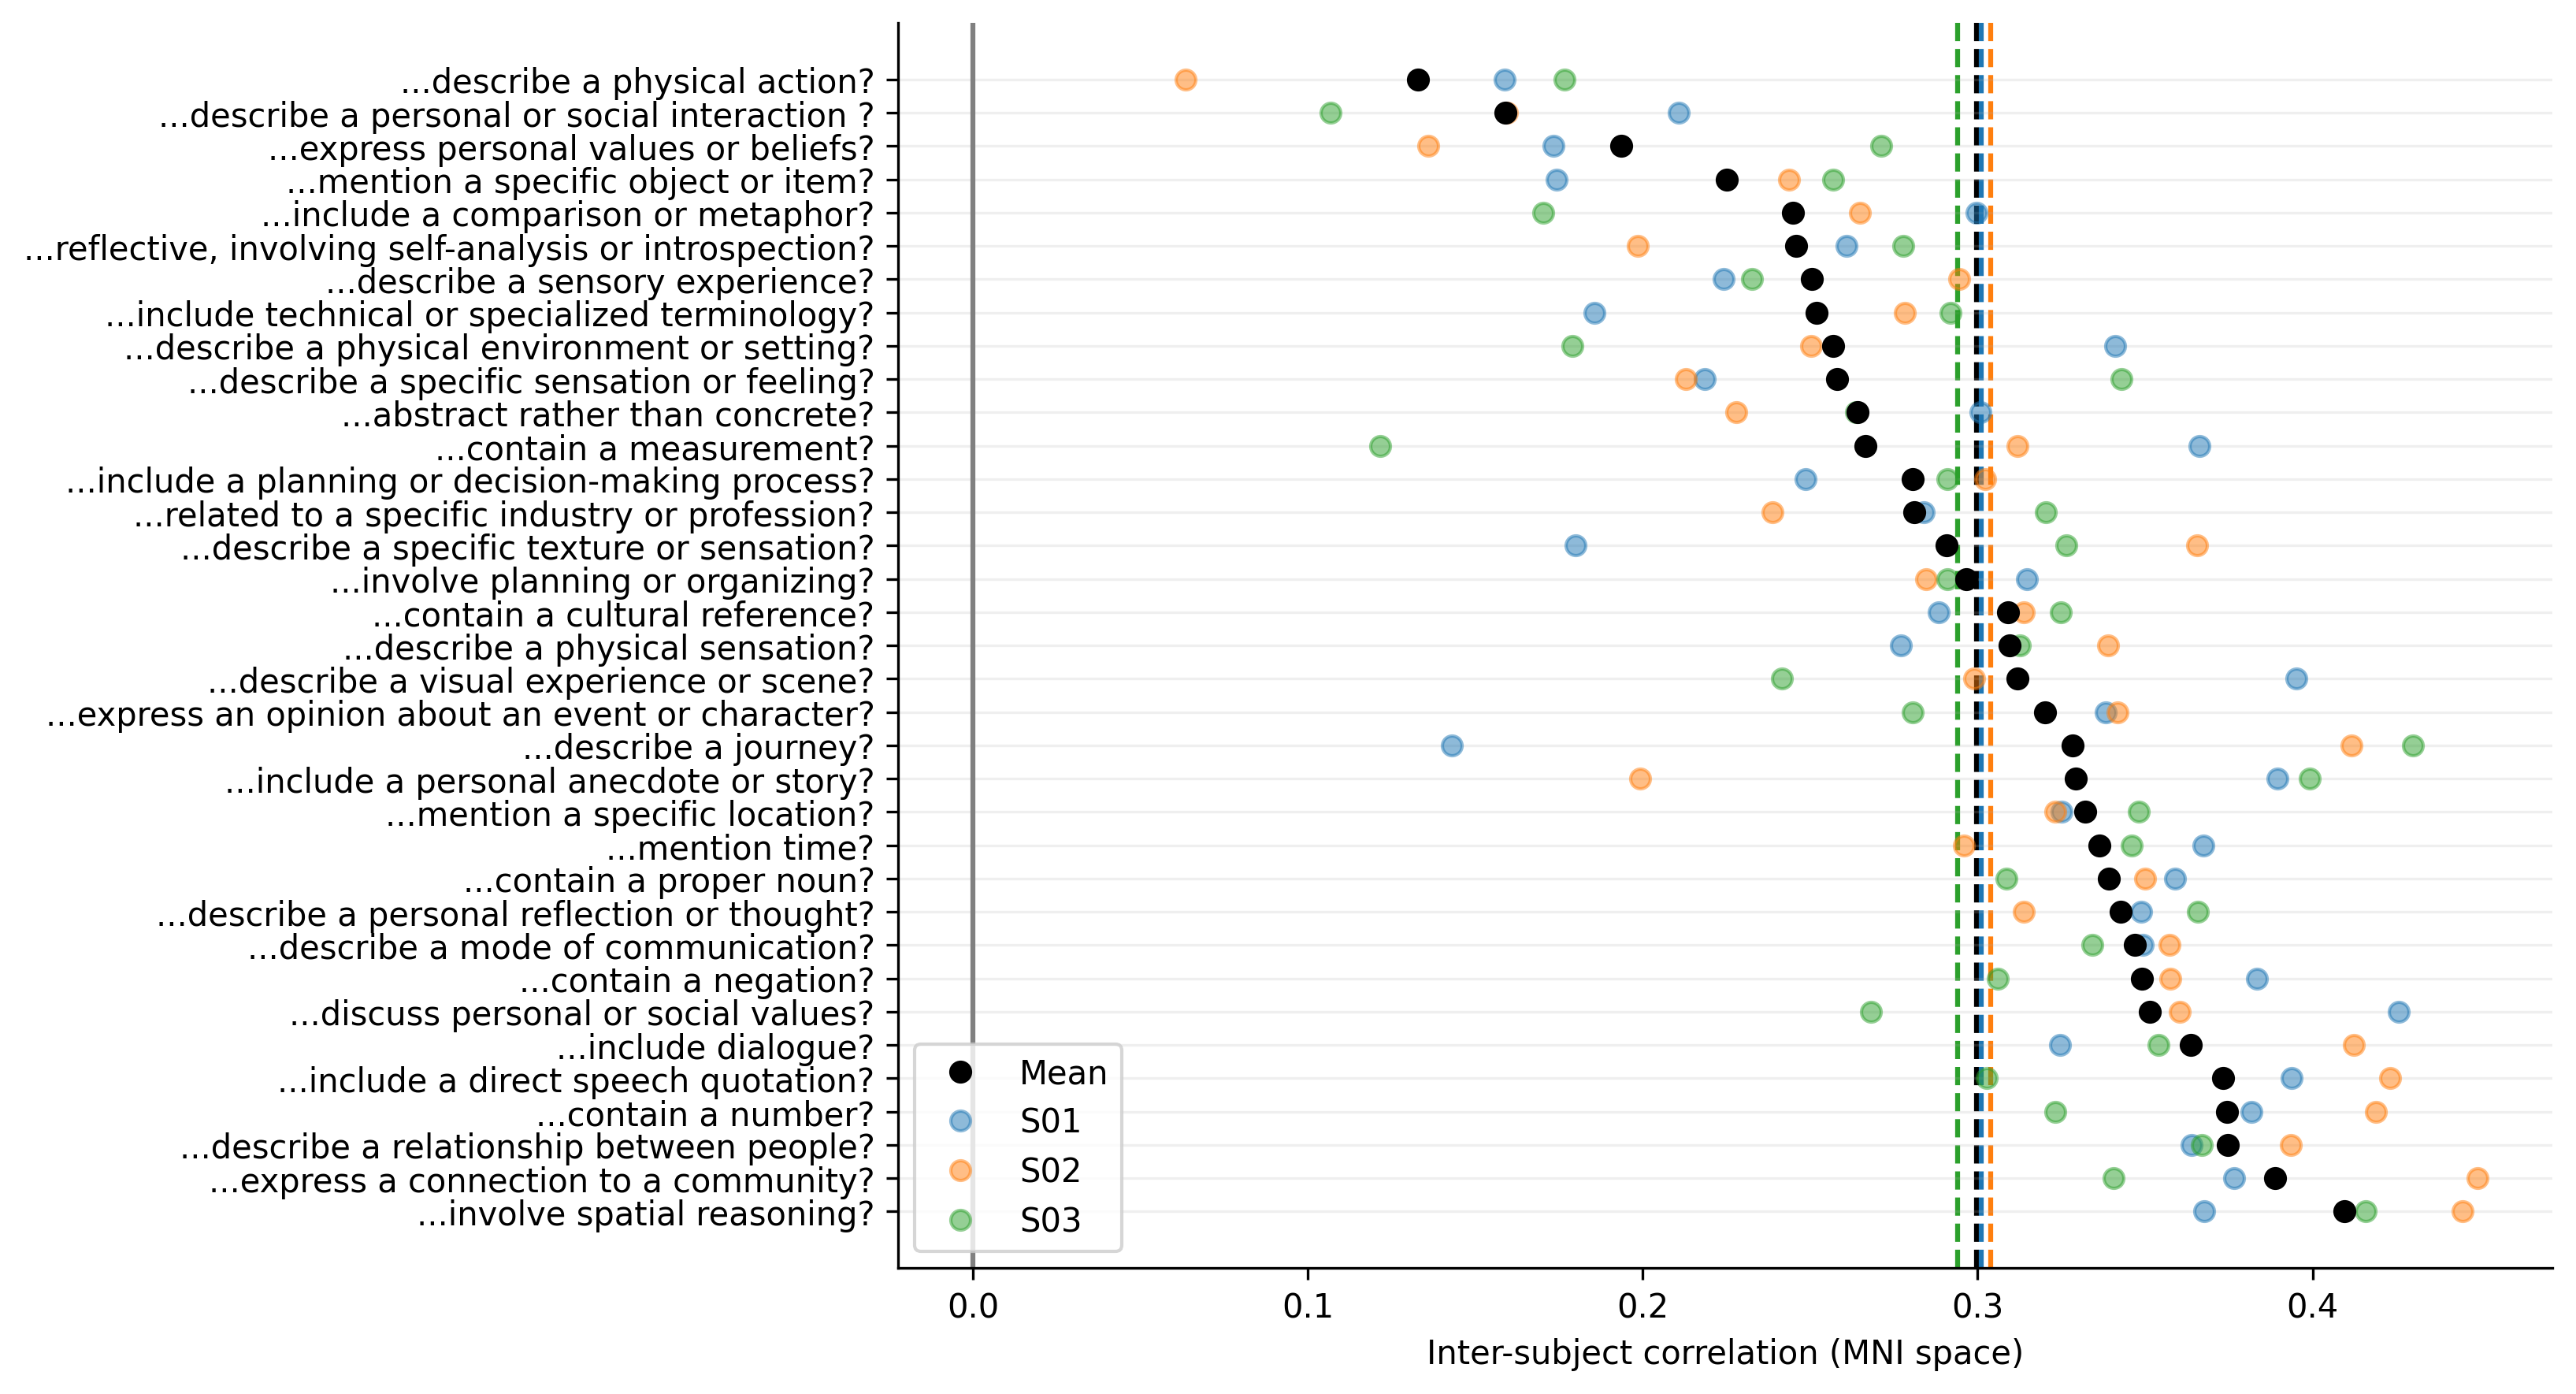

In [7]:
plt.figure(figsize=(11, 6), dpi=300)
neurosynth_compare.plot_corrs_df(
    corrs_df,
    out_dir='intersubject',
    plot_val=f'corrs',
    xlab=f'Inter-subject correlation (MNI space)',
)
plt.show()